<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [291]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re
import string

# Visualizaciones
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report



from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
from collections import Counter




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [292]:
df = pd.read_csv("../../datos/datos_fin.csv", index_col=0)

In [293]:
df.dtypes

reviewId               object
reviewDate             object
mainDepartment         object
subDepartment          object
productName            object
reviewTitle            object
reviewStar            float64
reviewText             object
inconsistentStatus      int64
dtype: object

In [294]:
df_group = result = df.groupby("productName").agg({
    "reviewText": lambda x: ", ".join(str(val) for val in x if pd.notnull(val))  # Concatenar como texto
}).reset_index()


LIMPIEZA DF

In [295]:
df_group.dropna(inplace= True)
df_group.isna().sum()

productName    0
reviewText     0
dtype: int64

In [296]:
df_group.dtypes

productName    object
reviewText     object
dtype: object

Sistema de recomendación

In [297]:
df.columns

Index(['reviewId', 'reviewDate', 'mainDepartment', 'subDepartment',
       'productName', 'reviewTitle', 'reviewStar', 'reviewText',
       'inconsistentStatus'],
      dtype='object')

In [298]:
df_final = df_group.copy()

In [299]:
df_final.head()

productName  \
0                                                                                                                                             (Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked   
1                                                                             AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml   
2                                                                                             AKASO EK7000 4K30FPS Action Camera Ultra HD Underwater Camera 170 Degree Wide Angle 98FT Waterproof Camera   
3  ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01   
4  Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6" Full HD IPS | AMD Ryzen 3 3350U Quad-Core Mobile Processor | 4GB DDR4 | 128GB NVMe SSD | WiFi 6 | Backlit KB | Amazon Alexa | Windows 10 Home (S mode)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [300]:
nltk.download("stopwords")
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [301]:
# Funcion Ana
def limpiar_texto(text):
    if isinstance(text, str):
        text = contractions.fix(text)

        text = text.lower()
        text = re.sub(r"[^\w\s]", "", text)
        text = re.sub(r"\s+", " ", text)
        text = text.strip()
        # doc = nlp(text)


        # tokens = [token.lemma_ for token in doc if token.text not in stop_words]
        return text
    else:
        pass

df_final["tags"] = df_final["reviewText"].apply(limpiar_texto)
df_final.head()

productName  \
0                                                                                                                                             (Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked   
1                                                                             AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml   
2                                                                                             AKASO EK7000 4K30FPS Action Camera Ultra HD Underwater Camera 170 Degree Wide Angle 98FT Waterproof Camera   
3  ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01   
4  Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6" Full HD IPS | AMD Ryzen 3 3350U Quad-Core Mobile Processor | 4GB DDR4 | 128GB NVMe SSD | WiFi 6 | Backlit KB | Amazon Alexa | Windows 10 Home (S mode)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [302]:
productos_unicos = (df_final["productName"].unique())

dic_renaming = {}
for indice,producto in enumerate(productos_unicos):

    dic_renaming[producto] = f"producto_{indice}"


In [303]:
dic_renaming

{'(Refurbished) Apple iPhone 7, 32GB, Black - Fully Unlocked': 'producto_0',
 'AIMEILI Gel Nail Polish No Wipe Top and Base Coat Set, Shine Finish and Long Lasting, Soak Off Gel Nail Lacquer - 2 x 10ml': 'producto_1',
 'AKASO EK7000 4K30FPS Action Camera Ultra HD Underwater Camera 170 Degree Wide Angle 98FT Waterproof Camera': 'producto_2',
 'ASUS Laptop L210 Ultra Thin Laptop, 11.6” HD Display, Intel Celeron N4020 Processor, 4GB RAM, 64GB Storage, NumberPad, Windows 10 Home in S Mode with One Year of Microsoft 365 Personal, L210MA-DB01': 'producto_3',
 'Acer Aspire 5 A515-46-R14K Slim Laptop | 15.6" Full HD IPS | AMD Ryzen 3 3350U Quad-Core Mobile Processor | 4GB DDR4 | 128GB NVMe SSD | WiFi 6 | Backlit KB | Amazon Alexa | Windows 10 Home (S mode)': 'producto_4',
 'Ailun Glass Screen Protector Compatible for iPhone 11/iPhone XR, 6.1 Inch 3 Pack Tempered Glass': 'producto_5',
 'Amazon Basics Ergonomic Office Desk Chair with Armrests, Adjustable Height/Tilt, 360-Degree Swivel, 275Lb Cap

In [304]:
print(len(dic_renaming))

df_final["productName"] = df_final["productName"].replace(dic_renaming)

99


In [305]:
df_final = df_final.drop_duplicates()
df_final.reset_index(inplace=True, drop=True)

In [306]:
df_final.head()

productName  \
0  producto_0   
1  producto_1   
2  producto_2   
3  producto_3   
4  producto_4   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [307]:
df_final["productName"].value_counts()

productName
producto_0     1
producto_1     1
producto_2     1
producto_3     1
producto_4     1
              ..
producto_94    1
producto_95    1
producto_96    1
producto_97    1
producto_98    1
Name: count, Length: 99, dtype: int64

In [308]:
from sklearn.feature_extraction.text import CountVectorizer # Vectorizacion / tokenizacion 
from sklearn.metrics.pairwise import cosine_similarity #  Cosine Similarity post Vectorizacion
import sys
sys.path.append("../")
from src import soporte_sistemas_recomendacion as sr


In [309]:
# realizamos la vectorización, es decir, convertimos el texto a vectores para poder calcular las distancias entre películas
vectorizer = CountVectorizer(max_features=1000,stop_words= "english")

# vectorizamos la columna objetivo
X = vectorizer.fit_transform(df_final['tags']).toarray()

# calculamos sus distancias
similarity = cosine_similarity(X)
similarity[:20]

array([[1.        , 0.23318699, 0.40529071, ..., 0.32782922, 0.25123289,
        0.32460001],
       [0.23318699, 1.        , 0.34012823, ..., 0.30959534, 0.28124923,
        0.31721644],
       [0.40529071, 0.34012823, 1.        , ..., 0.44579142, 0.31245739,
        0.36706719],
       ...,
       [0.19485219, 0.25318384, 0.27316842, ..., 0.25797423, 0.22142352,
        0.22783909],
       [0.27645138, 0.38127009, 0.36334131, ..., 0.37552579, 0.36308903,
        0.35070516],
       [0.21354753, 0.32868467, 0.29115976, ..., 0.28754966, 0.27290549,
        0.26870445]])

In [311]:
df_final.columns

Index(['productName', 'reviewText', 'tags'], dtype='object')

In [312]:
producto_usuario = "producto_17"

# buscamos el inidice de la pelicula, ya que lo vamos a necesitar para nuestro objetivo
product_index = sr.get_index_from_title(producto_usuario,"productName", df_final)

# sacamos las peliculas similares
similar_products = list(enumerate(similarity[product_index]))
similar_products

[(0, np.float64(0.19485218507008026)),
 (1, np.float64(0.2531838395374327)),
 (2, np.float64(0.2731684166564949)),
 (3, np.float64(0.27371117079069607)),
 (4, np.float64(0.2582230638148631)),
 (5, np.float64(0.23394813312761478)),
 (6, np.float64(0.20145656151525904)),
 (7, np.float64(0.19702283906443774)),
 (8, np.float64(0.1010356840107782)),
 (9, np.float64(0.2704903591478672)),
 (10, np.float64(0.29000819424391244)),
 (11, np.float64(0.20694107745609217)),
 (12, np.float64(0.24885437256527465)),
 (13, np.float64(0.2559066297871631)),
 (14, np.float64(0.23637989370598333)),
 (15, np.float64(0.1960466794115855)),
 (16, np.float64(0.22555603596214124)),
 (17, np.float64(0.9999999999999999)),
 (18, np.float64(0.2689098404844219)),
 (19, np.float64(0.20231849550335793)),
 (20, np.float64(0.21990618946285806)),
 (21, np.float64(0.1955351412239959)),
 (22, np.float64(0.18862596464206033)),
 (23, np.float64(0.27141584661156326)),
 (24, np.float64(0.2661765440566775)),
 (25, np.float64(0.30

In [313]:
# ordenamos los productos
productos_similares_ordenados = sorted(similar_products,key=lambda x:x[1],reverse=True)[1:50]
len(productos_similares_ordenados)

49

In [314]:
productos_similares_ordenados

[(52, np.float64(0.3550891651065064)),
 (30, np.float64(0.3362229022218756)),
 (31, np.float64(0.3345440109270398)),
 (25, np.float64(0.30726058482682256)),
 (91, np.float64(0.3012784783699982)),
 (54, np.float64(0.29918112934392166)),
 (51, np.float64(0.2951444015729314)),
 (81, np.float64(0.2917036499360635)),
 (10, np.float64(0.29000819424391244)),
 (43, np.float64(0.28885695669665357)),
 (72, np.float64(0.2884582013535185)),
 (94, np.float64(0.2883729430333384)),
 (50, np.float64(0.2805223141871001)),
 (48, np.float64(0.28005804448809785)),
 (63, np.float64(0.2740293070838235)),
 (3, np.float64(0.27371117079069607)),
 (2, np.float64(0.2731684166564949)),
 (35, np.float64(0.2728508101610667)),
 (38, np.float64(0.2722973710675294)),
 (77, np.float64(0.2717829943336772)),
 (23, np.float64(0.27141584661156326)),
 (67, np.float64(0.2711080950321156)),
 (9, np.float64(0.2704903591478672)),
 (18, np.float64(0.2689098404844219)),
 (47, np.float64(0.2683874478103309)),
 (58, np.float64(0.26

C:\Users\Victor\AppData\Local\Temp\ipykernel_27396\3140081480.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


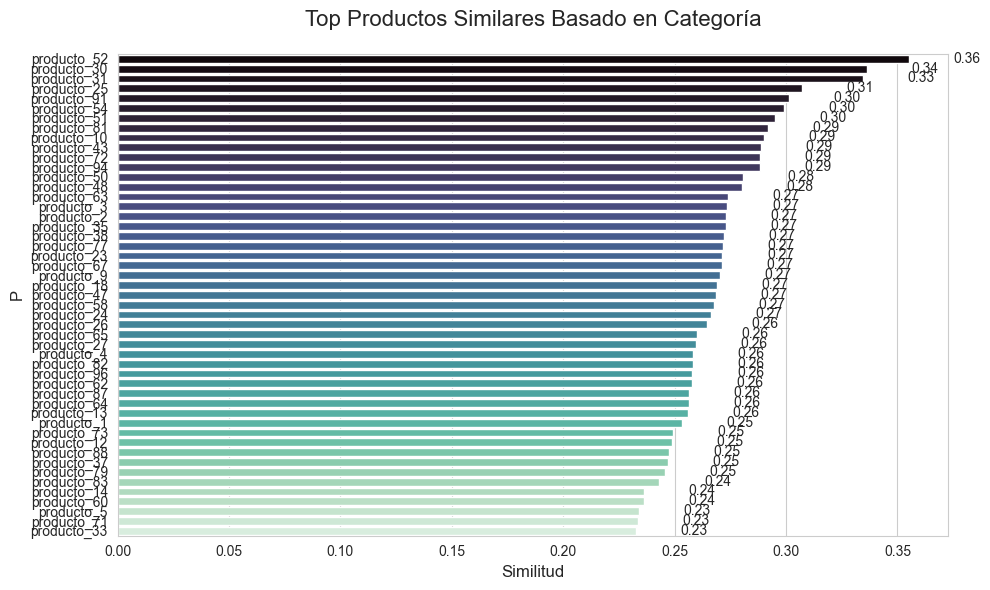

In [315]:
# y ahora buscamos el título
top_similar_products = {}
for i in productos_similares_ordenados:
    top_similar_products[sr.get_title_from_index(i[0],column_name="productName", dataframe= df_final)] = i[1]

# visualizamos los resultados
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Crear gráfico de barras
sns.barplot(
    x=list(top_similar_products.values()), 
    y=list(top_similar_products.keys()), 
    palette="mako"
)

# Añadir etiquetas y título
plt.title("Top Productos Similares Basado en Categoría", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("P", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(top_similar_products.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout()
